In [1]:
from robust_analysis import ridge_estimator, train_robust_model,compute_weights, leave_one_out, \
                            leave_one_out_procedure, cross_validation_loo,\
                            leave_one_out_ridge, leave_one_out_procedure_ridge, cross_validation_loo_ridge

ImportError: cannot import name 'leave_one_out_ridge' from 'robust_analysis' (/home/vcohen/cope/robust_analysis.py)

In [3]:
import pickle
import os 
import netCDF4 as netcdf
import skimage
import numpy as np

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))


# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))


# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}


for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
        else:
            mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
    
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = dic_processed_ssp585[m][i] - mean_ref_ensemble


# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_spatial_ensemble = 0
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
        else:
            mean_spatial_ensemble += np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
            
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.mean(mean_spatial_ensemble[131:164])


time_period = 33
grid_lat_size = 36
grid_lon_size = 72

y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = 0
    x_predictor[m] = 0
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        if idx_i ==0:
            y_forced_response[m] = dic_forced_response_ssp585[m][i][131:164]
            x_predictor[m] = dic_processed_ssp585[m][i][131:164,:,:]
        else:
            y_forced_response[m] = np.concatenate([y_forced_response[m],dic_forced_response_ssp585[m][i][131:164]])
            x_predictor[m] = np.concatenate([x_predictor[m], dic_processed_ssp585[m][i][131:164,:,:]],axis=0)    

# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    arr_tmp = np.zeros((len(dic_processed_ssp585[m].keys()),33))
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        arr_tmp[idx_i,:] = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=(1,2))
    variance_processed_ssp585[m] = np.mean(np.var(arr_tmp,axis=0))
    std_processed_ssp585[m] = np.mean(np.std(arr_tmp,axis=0))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


/tmp/ipykernel_14354/2211219033.py:70: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
/tmp/ipykernel_14354/2211219033.py:72: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])


In [4]:
import torch 

# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = torch.from_numpy(np.nan_to_num(x_predictor[m]).reshape(x_predictor[m].shape[0],x_predictor[m].shape[1]*x_predictor[m].shape[2])).to(torch.float64)
    y_train[m] = torch.from_numpy(np.nan_to_num(y_forced_response[m])).to(torch.float64)

    nans_idx = np.where(np.isnan(x_predictor[m][0,:,:].ravel()))[0]


alpha_range = np.array([0.15, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0])
lambda_range = np.array([0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0])


with open('alpha_range.npy', 'wb') as f:
    np.save(f, alpha_range)

with open('lambda_range.npy', 'wb') as f:
    np.save(f, lambda_range)

# Read the results.

In [6]:
# read robust regression files
file = open('results/betas_robust.pkl', 'rb')
beta_robust = pickle.load(file)
file.close()

file = open('results/rmse_robust.pkl', 'rb')
rmse_robust = pickle.load(file)
file.close()

file = open('results/weight_robust.pkl', 'rb')
weights_robust = pickle.load(file)
file.close()

In [7]:
alpha_range = np.array([0.15, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0])
lambda_range = np.array([0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0])

rmse_robust_record = np.zeros(len(list(rmse_robust.keys())))

for idx_lambda,lambda_ in enumerate(list(rmse_robust.keys())):
    m_worst_loo = max(rmse_robust[lambda_], key=rmse_robust[lambda_].get)
    rmse_robust_record[idx_lambda] = rmse_robust[lambda_][m_worst_loo]

In [8]:
a_map = np.zeros((alpha_range.shape[0],lambda_range.shape[0]))

# for each pair (alpha, lambda)
for idx_alpha, alpha_ in enumerate(alpha_range):

    # for each lambda:
    for idx_lambda, lambda_ in enumerate(lambda_range):
        a_map[idx_alpha,idx_lambda] = np.array(list(rmse_robust[(alpha_,lambda_)].values())).max()

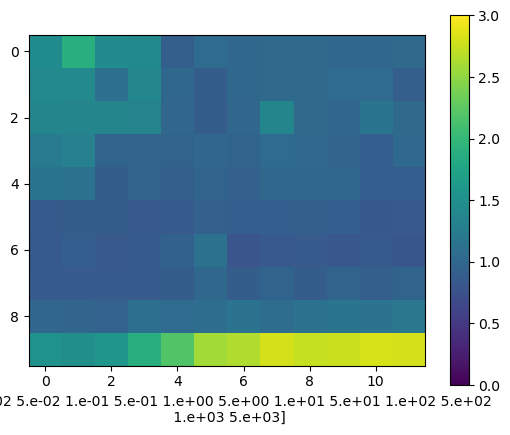

In [15]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(a_map,vmin=0.0, vmax=3.0)
plt.colorbar()
plt.xlabel(lambda_range)
plt.savefig("results/rmse_map_.eps", dpi=150)
plt.show()

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


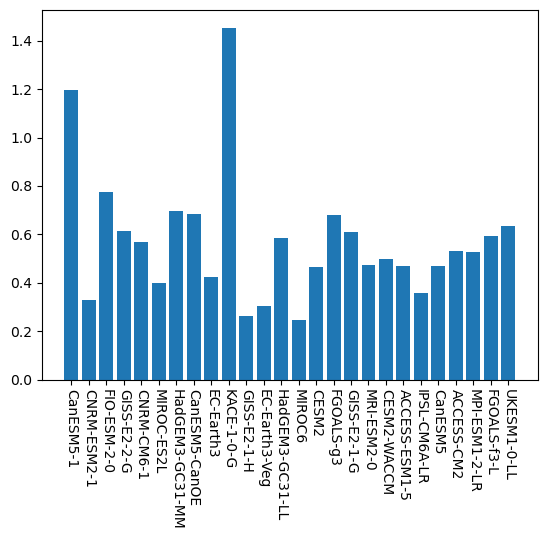

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


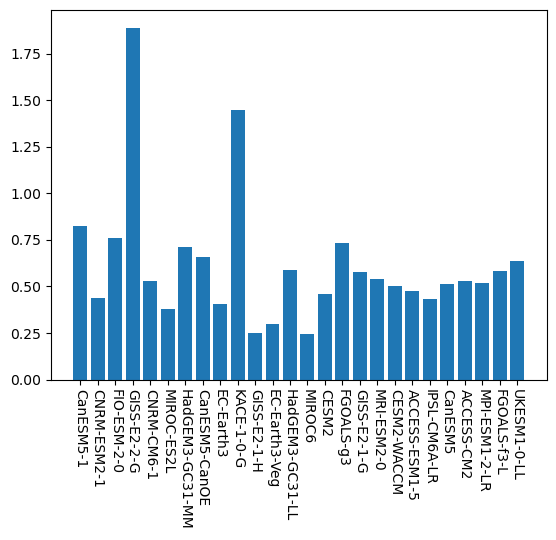

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


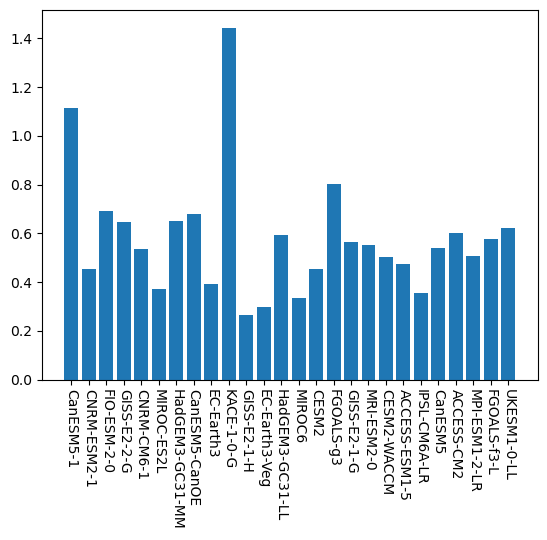

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


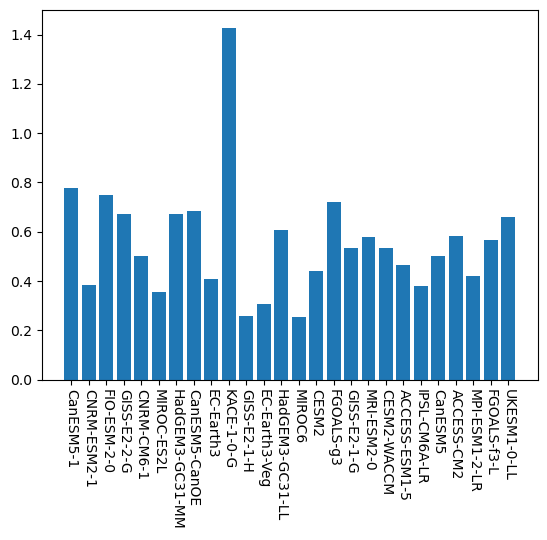

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


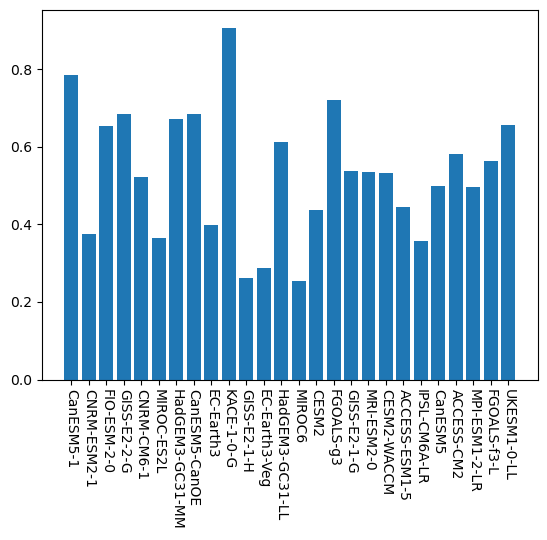

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


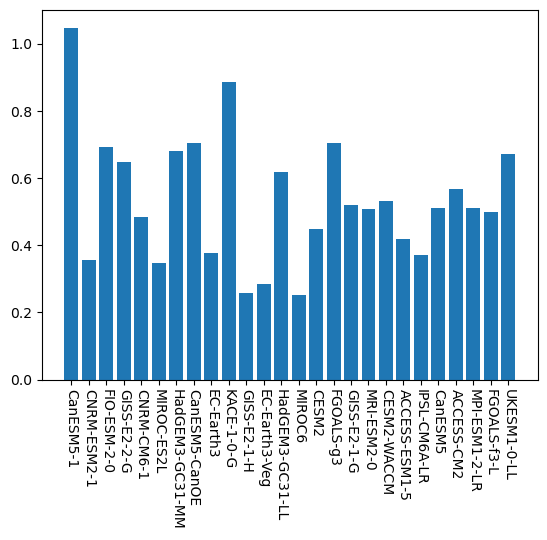

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


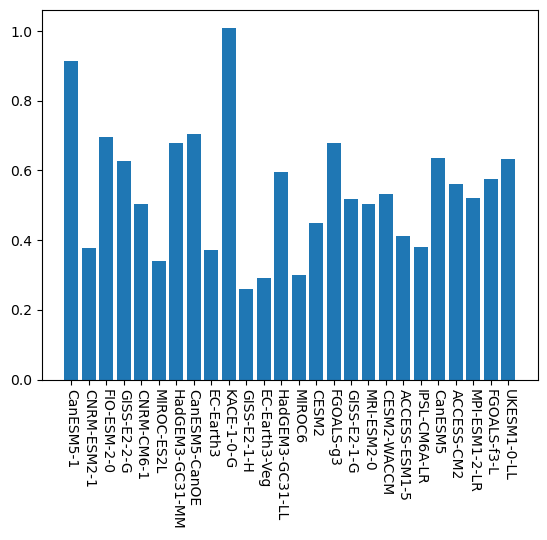

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


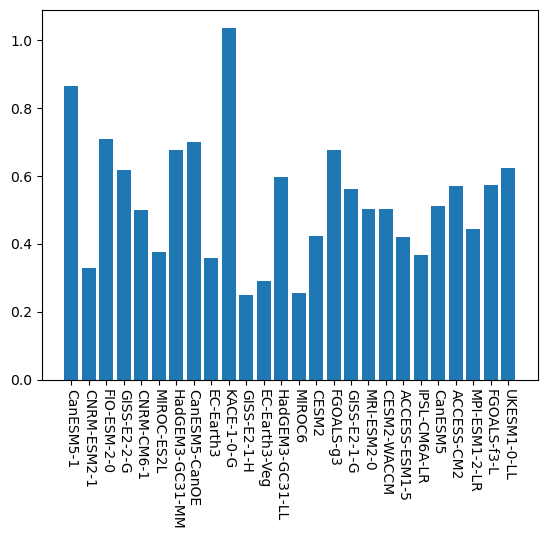

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


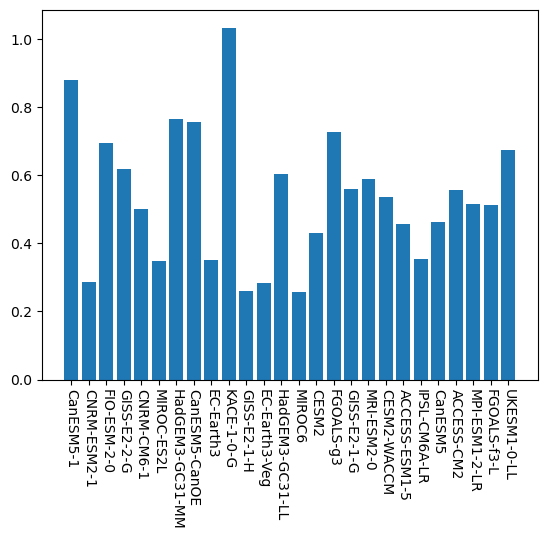

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


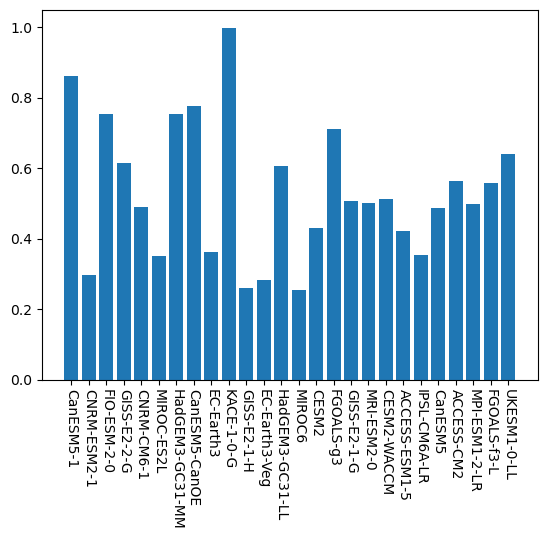

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


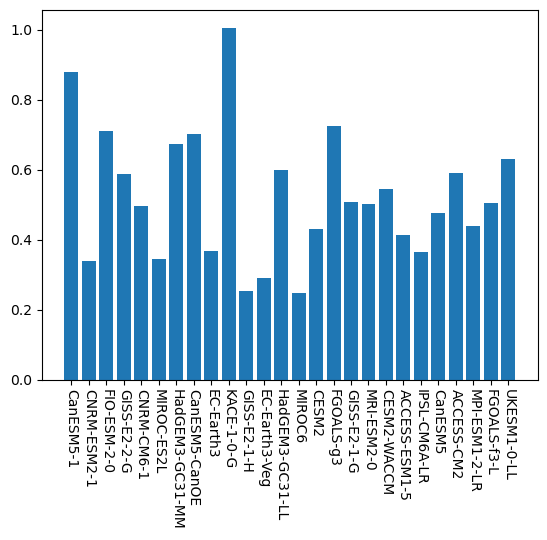

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


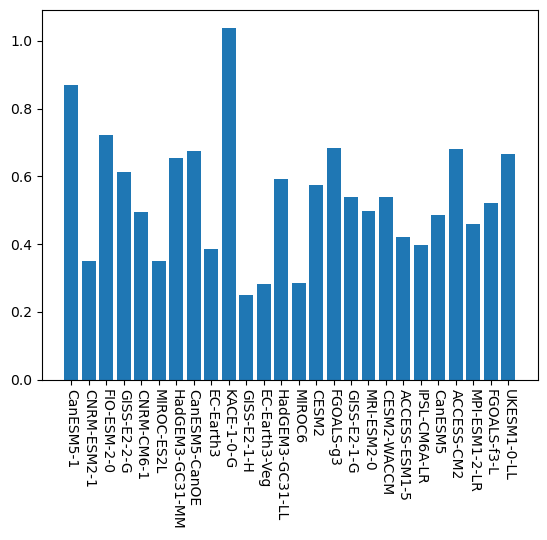

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


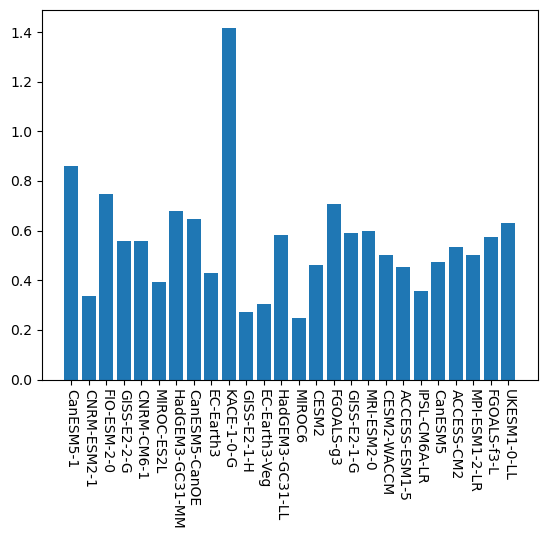

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


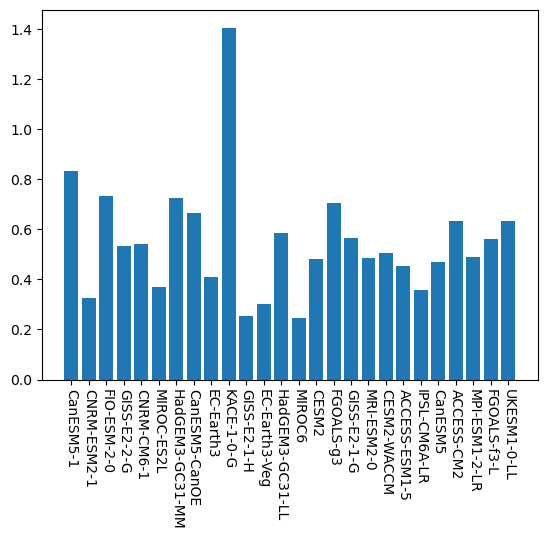

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


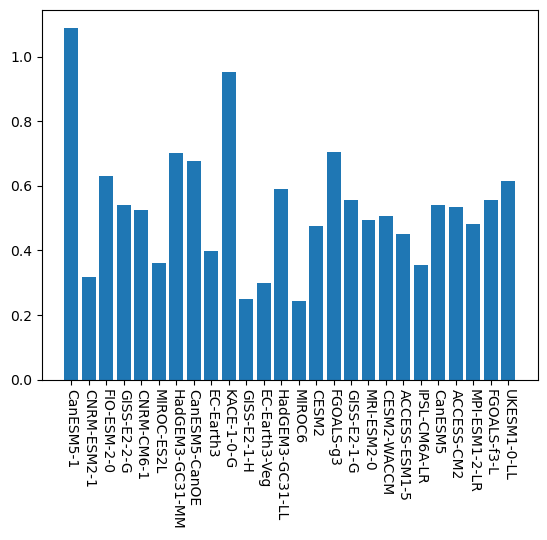

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


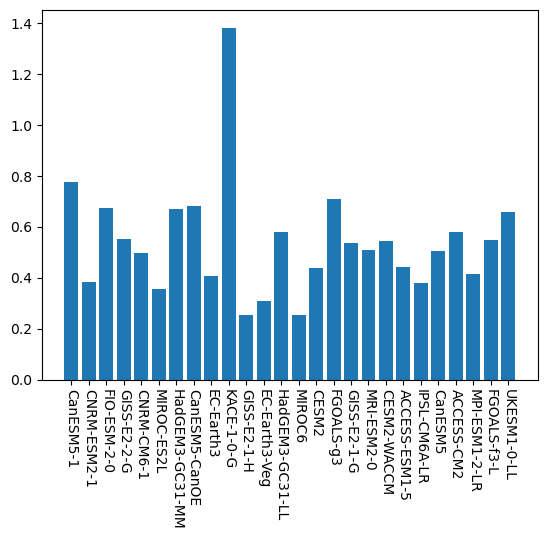

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


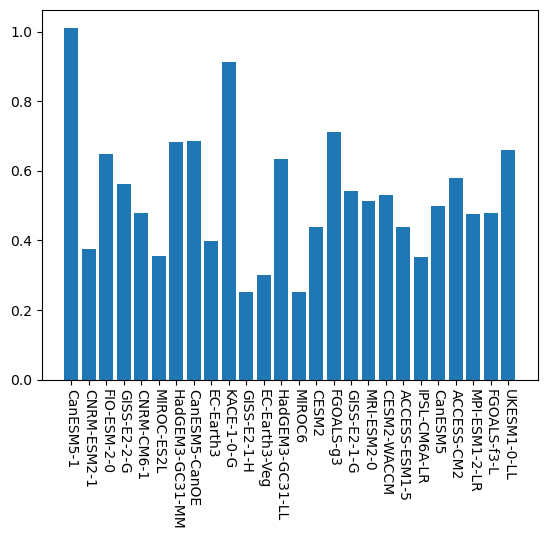

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


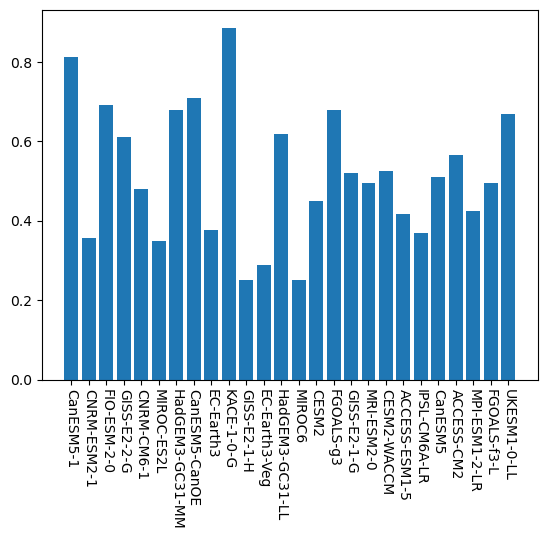

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


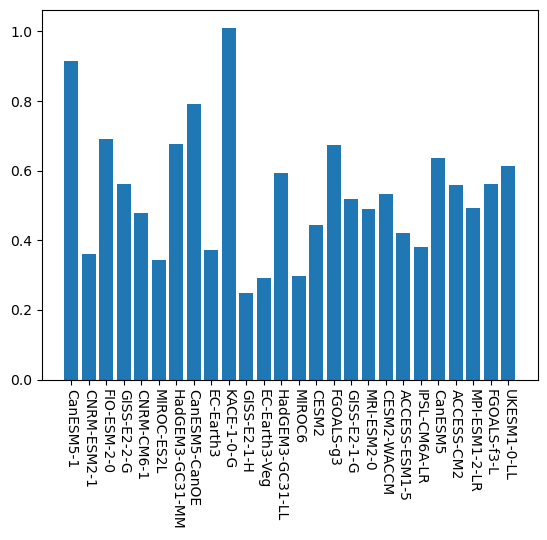

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


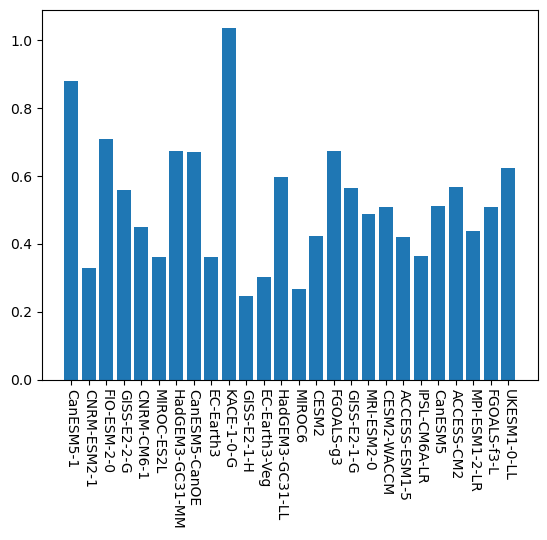

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


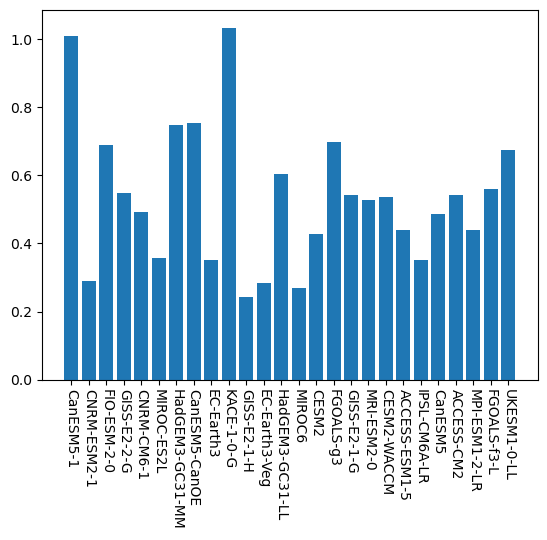

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


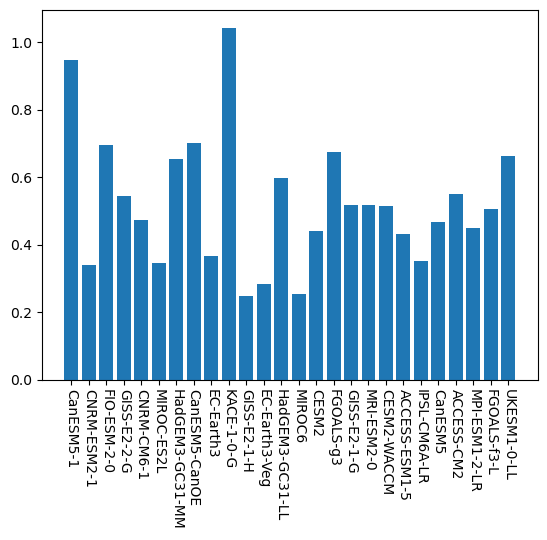

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


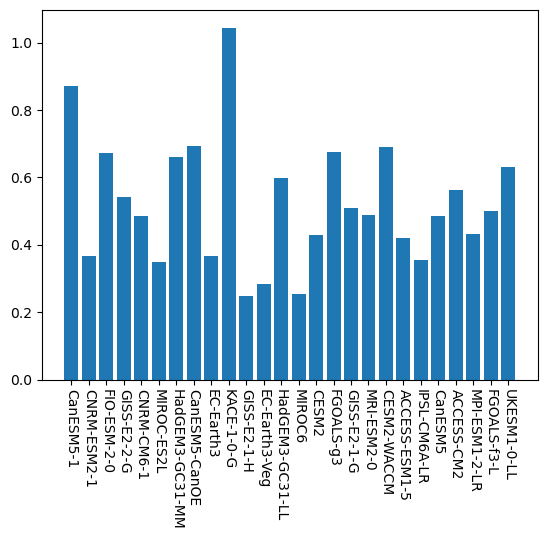

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


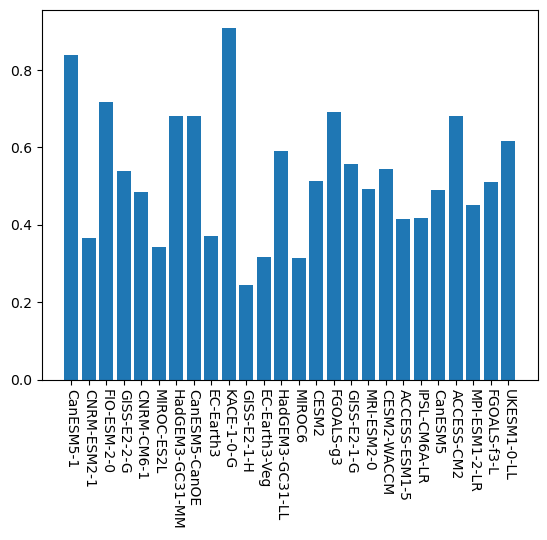

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


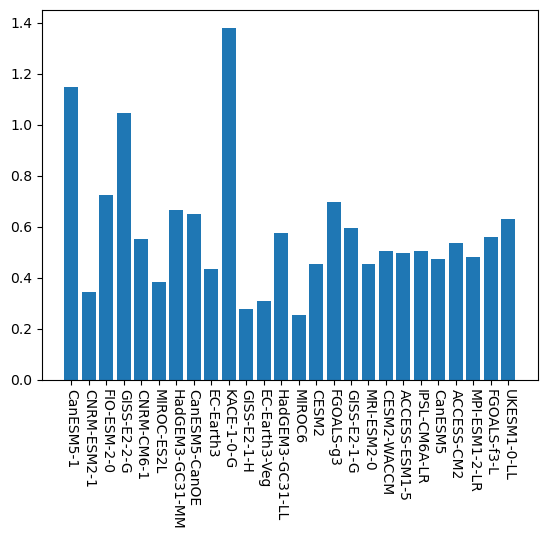

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


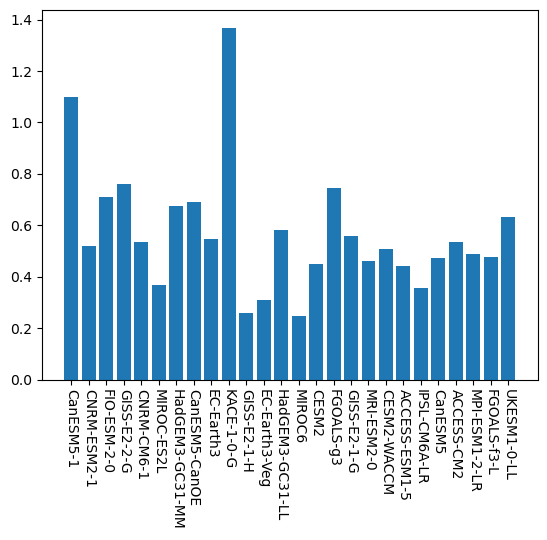

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


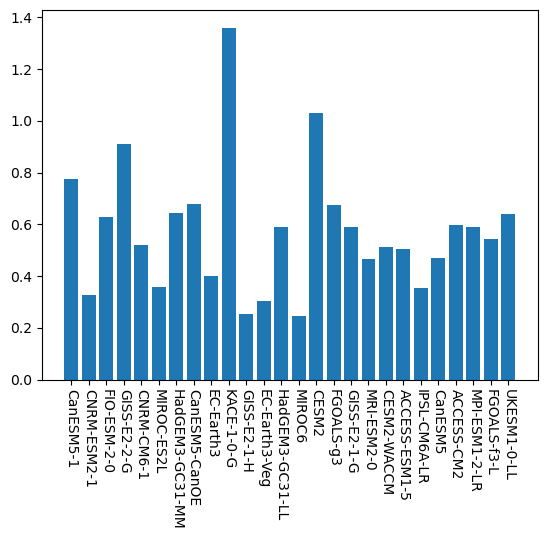

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


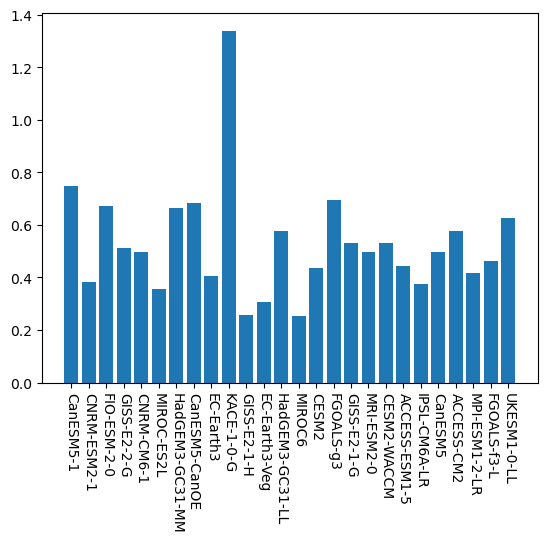

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


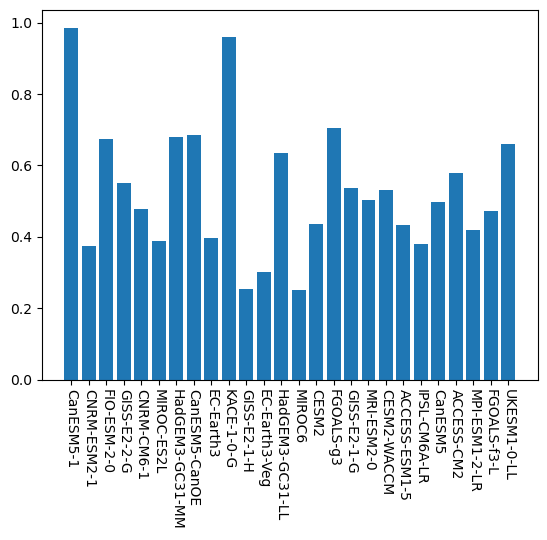

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


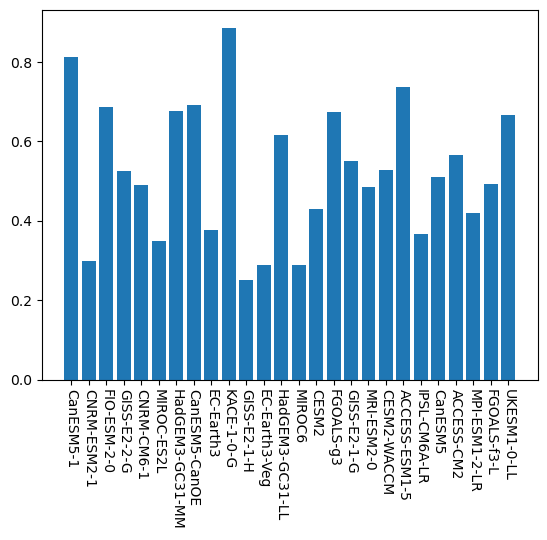

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


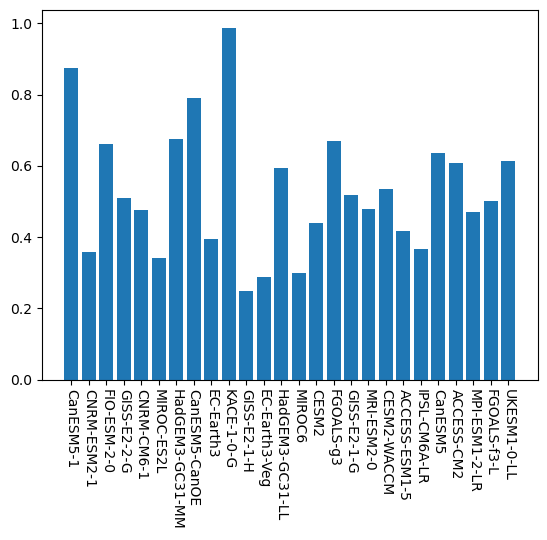

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


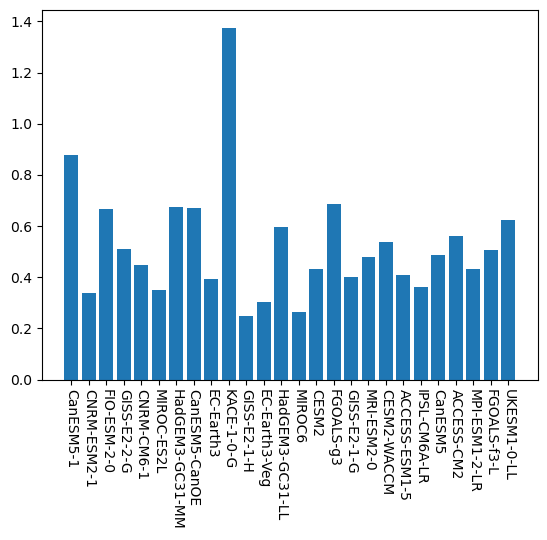

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


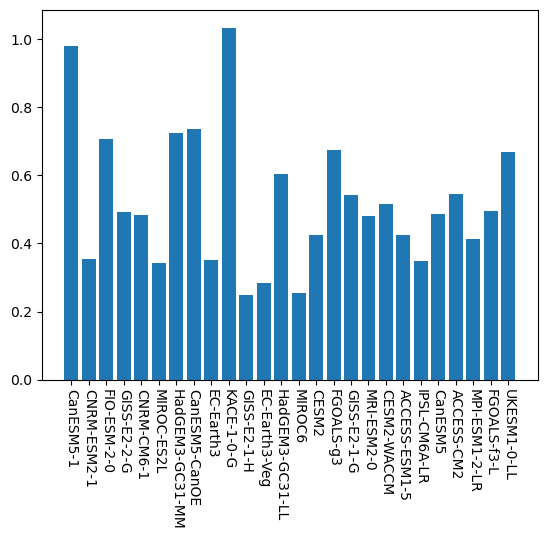

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


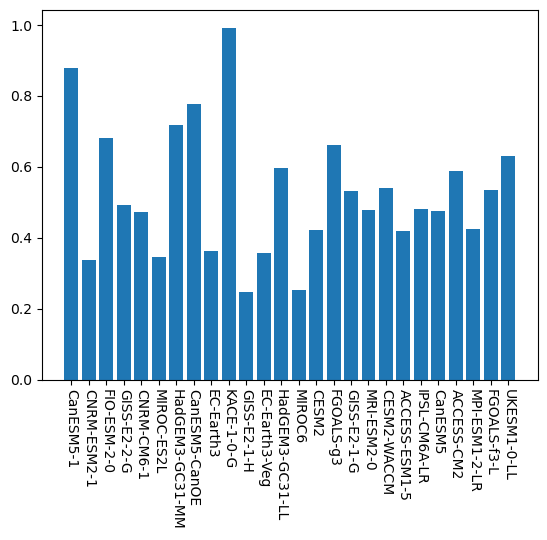

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


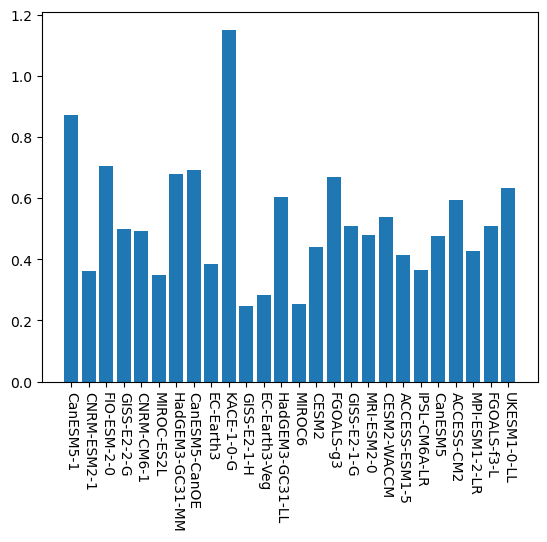

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


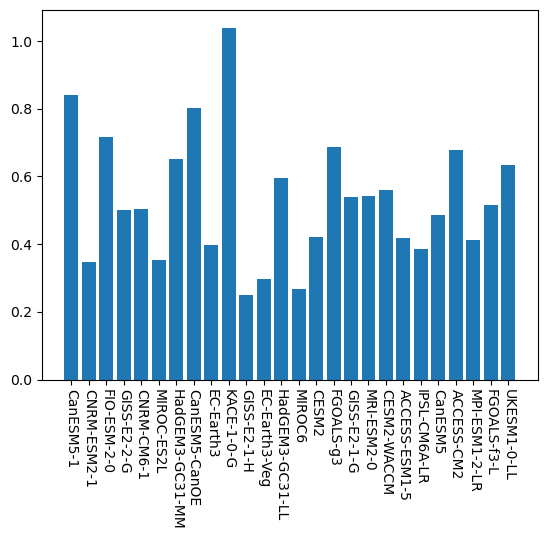

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


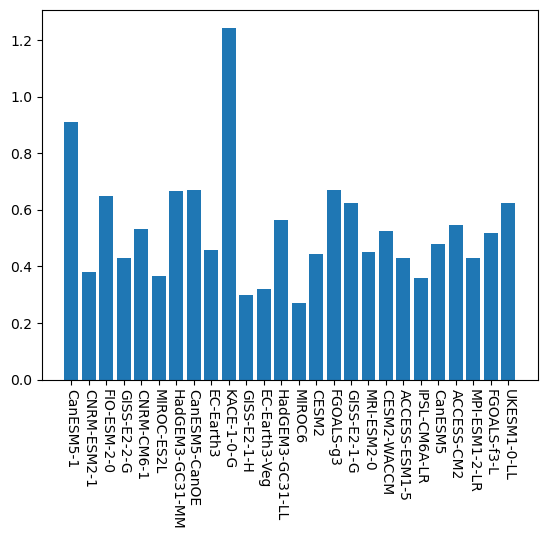

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


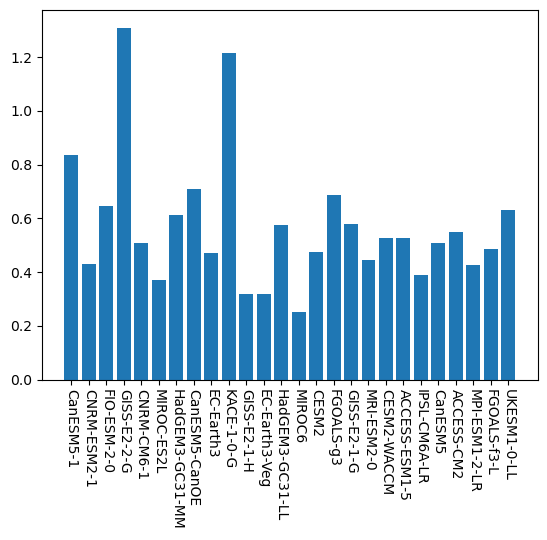

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


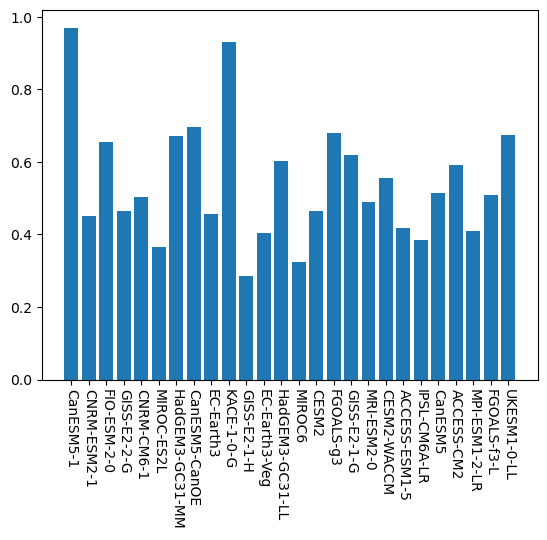

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


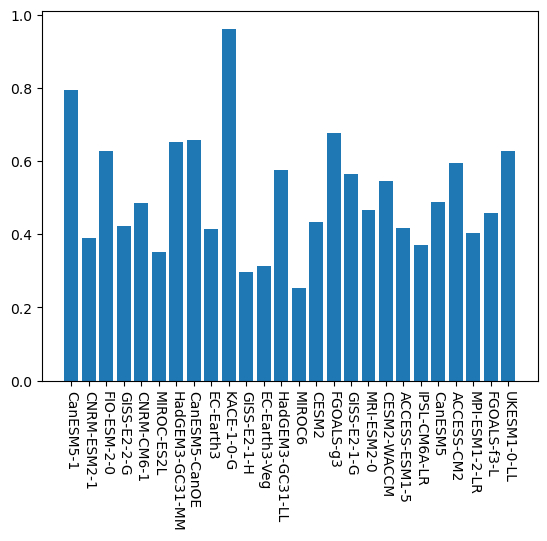

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


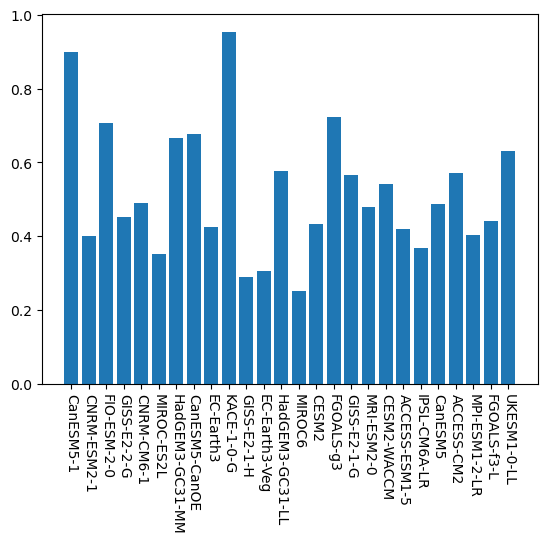

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


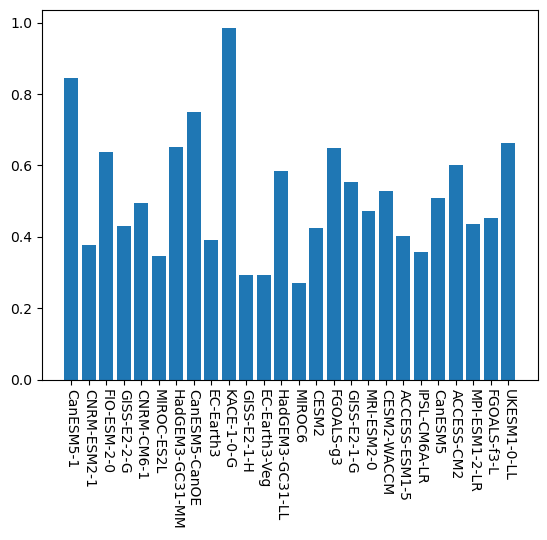

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


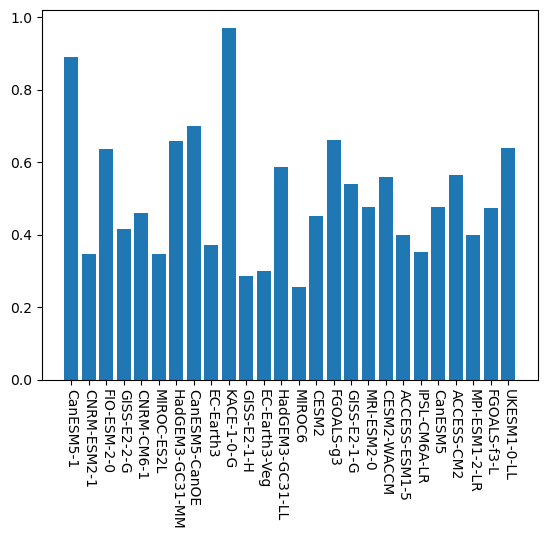

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


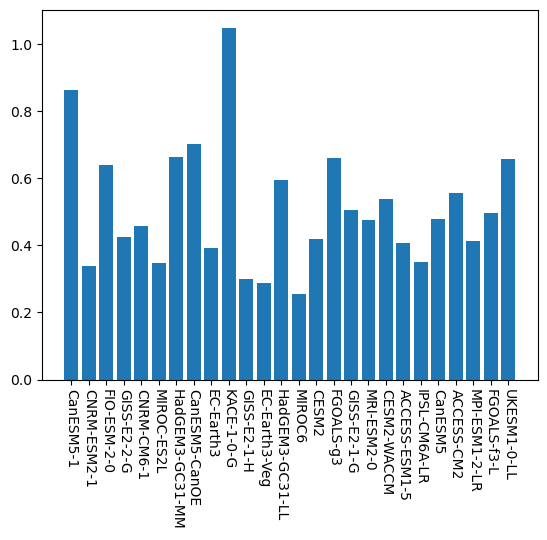

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


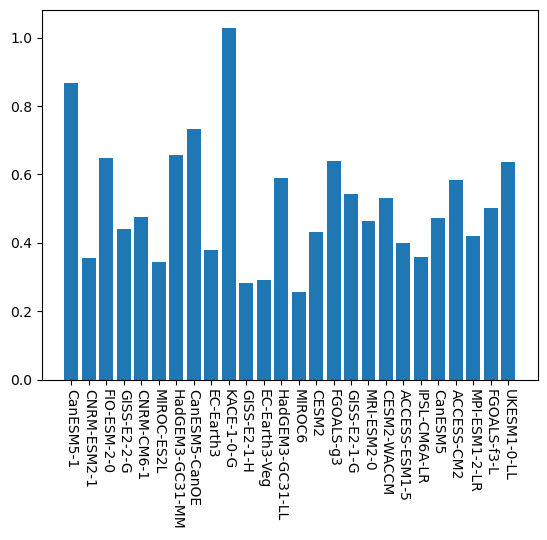

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


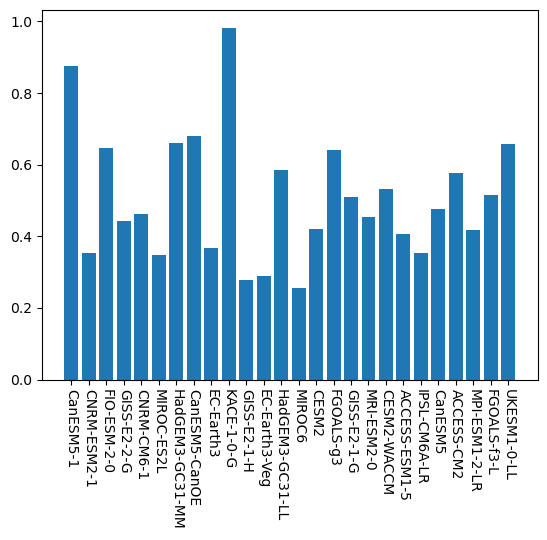

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)


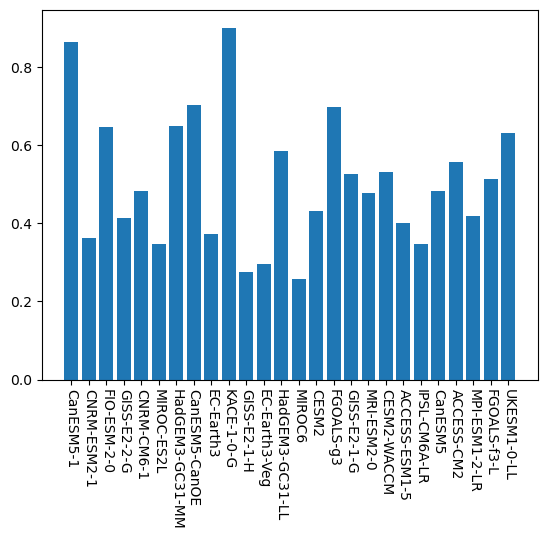

/tmp/ipykernel_14354/3175180020.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f690e6e6640>>
Traceback (most recent call last):
  File "/home/vcohen/.conda/envs/cope/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f690e6e6640>>
Traceback (most recent call last):
  File "/home/vcohen/.conda/envs/cope/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [18]:
######## Plot LOO(m) for different value of alpha. (Make a gif or animation)
loo_alpha_lambda = np.zeros((alpha_range.shape[0],lambda_range.shape[0]))

# for each lambda:
for idx_lambda, lambda_ in enumerate(lambda_range):    

    # for each pair (alpha, lambda)
    for idx_alpha, alpha_ in enumerate(alpha_range):
        
        loo_alpha_lambda = np.array(list(rmse_robust[(alpha_,lambda_)].values()))
        
        # Bar plot
        fig, ax = plt.subplots()
        ax.bar(x = list(rmse_robust[(alpha_,lambda_)].keys()), height = loo_alpha_lambda)
        ax.set_xticklabels(list(rmse_robust[(alpha_,lambda_)].keys()), rotation=-90)
        plt.show()

In [105]:
from matplotlib import animation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

n=100 #Number of frames
x= list(dic_processed_ssp585.keys())
barcollection = plt.bar(x,list(np.ones(len(x))))
ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)
ax.set_ylim(0.0,2.0)

# def animate(t):
#     plt.cla()
#     plt.plot(x-t,x)
#     plt.xlim(0,10)

def animate_rmse(i):
    ax.set_title('alpha = '+ str(alpha_range[i]))
    for k, b in enumerate(barcollection):
        b.set_height(list(rmse_robust[(alpha_range[i],lambda_range[0])].values())[k])
    

ani = animation.FuncAnimation(fig, animate, frames=alpha_range.shape[0])
ani.save('robust_loo_rmse.mp4',writer=animation.FFMpegWriter(fps=10))

/tmp/ipykernel_14354/117814274.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)
/home/vcohen/.conda/envs/cope/lib/python3.9/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [106]:
fig, ax = plt.subplots()

n=100 #Number of frames
x= list(dic_processed_ssp585.keys())
barcollection = plt.bar(x,list(np.ones(len(x))))
ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)
ax.set_ylim(0.0,1.5)


def animate_weight(i):
    ax.set_title('alpha = '+ str(alpha_range[i]))
    for k, b in enumerate(barcollection):
        # b.set_height(np.random.rand())
        b.set_height(list(weight_robust[(alpha_range[i],lambda_range[0])].values())[k])

ani_weight = animation.FuncAnimation(fig, animate, frames=alpha_range.shape[0])
ani_weight.save('robust_weights.mp4',writer=animation.FFMpegWriter(fps=10))

/tmp/ipykernel_14354/2122381432.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)
